# Baroclinic instability in a pizza box

v2.5 28 May 2018 by Brian Fiedler

$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\B}[1]{\overline{#1}}$ 
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\dd}[2]{\frac{\D#1}{\D#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\VU}{\V{U}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$
$\newcommand{\VI}[1]{\left\langle#1\right\rangle}$
$\require{color}$

Well, not quite a pizza box, the domain is really much flatter, 2000 times as wide as deep. We use a Coriolis parameter that makes the [Rossby radius of deformation](https://en.wikipedia.org/wiki/Rossby_radius_of_deformation) about equal to 1/8 of the width of the domain.  So the domain is comparable to draping a pizza box over the north pole, stretched down to mid-latidues.  But we don't model Earth's curvature, the pizza box is on an [f-plane](https://en.wikipedia.org/wiki/F-plane).   

For the extra-tropical cyclones that we model, the horizontal scale is certainly large enough for the hydrostatic approximation to be valid.  

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output, Image
import time as Time
import math, os, glob
import numpy as np
import scipy.fftpack
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import urllib.request
#from crunchers3d import *

In [3]:
#HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

We prognosticate the following dimensionless equations:

$$
\pdt{u} + u \pd{u}{x} + v \pd{u}{y} + w \pd{u}{z}= - \pd{P}{x} + \frac{f}{N} v
$$

$$
\pdt{v}{t} + u \pd{v}{x} + v \pd{v}{y} + w \pd{v}{z}=  - \pd{P}{y} - \frac{f}{N} u
$$

This vertical momentum equation is NOT implemented:
$$
\pdt{w} + u \pd{w}{x} + v \pd{w}{y} + w \pd{w}{z}= - \pd{P}{z} + b 
$$

Instead, we implement the hydrostatic version:
$$
0 = - \pd{P}{z} + b 
$$


$$
\pd{u}{x} + \pd{v}{y} + \pd{w}{z}  = 0
$$

$$
\pdt{b} + u \pd{b}{x} + v \pd{b}{y} + w \pd{b}{z}= - w 
$$

The non-dimensionalization should be familiar to you. Note the time scale is $1/N$, not seconds.
In the code below, we use `fcoriolis`=$f/N$  

# Functions

## familiar:

In [4]:
################
def ab_blend(dqdt,order):
# blends the time derivatives for the 1st, 2nd and 3rd order Adams-Bashforth schemes
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")


##  Hydrostatic pressure solver for the 3-D C-grid

In [5]:
def poisson_p_fft_prep(Nxp,Nyp,dx,dy,lapl='discrete',periodic=False):
# returns the coefficients to multiply the vorticity Fourier amplitudes   
    L = dx*Nxp
    W = dy*Nyp
   
    Ka = np.arange(Nxp)  # the wavenumbers of the cos functions in the x-direction
    Ma = np.arange(Nyp)
        
    if periodic: Ka[1::2] += 1 # because both cos and sin
    
    ka = Ka*np.pi/L
    ma = Ma*np.pi/W

    lapl_op =np.zeros((Nyp,Nxp)) 
    if lapl == 'discrete':
        lapl_op[:] = (2*np.cos(ka*dx)-2)/dx**2
    else: # the calculus Laplacian
        lapl_op[:] += -ka**2
    lapl_opT=lapl_op.T # reverse columns and rows
    if lapl == 'discrete':
        lapl_opT[:] += (2*np.cos(ma*dy)-2)/dy**2 # add to every row
    else: # the calculus Laplacian
        lapl_opT[:] += -ma**2
    lapl_op=lapl_opT.T # reverse columns and rows
    lapl_op[0,0] = 1.
    invlapl = 1./lapl_op
    return invlapl

def poisson_p_fft(div,invlapl,periodic=False):
    sh = div.shape
    if periodic:
        divt = scipy.fftpack.rfft( div , axis=1) # discrete sin and cos transform of rows of div
    else:
        divt = scipy.fftpack.dct( div , axis=1, type=2) # discrete cos transform of rows of div
    
    divt = scipy.fftpack.dct( divt , axis=0, type=2) # discrete cos transform of rows of div
    
    pt = divt*invlapl
    
    pt = scipy.fftpack.idct(pt,axis=0,type=2) # inverse transform of pt to p
    if periodic:
        p = scipy.fftpack.irfft(pt,axis=1) # inverse transform of pt to p
        p = p/(2*sh[0]) #The need for this division is convention of fft
    else:
        p = scipy.fftpack.idct(pt,axis=1,type=2) # inverse transform of pt to p
        p = p/(4*sh[0]*sh[1]) #The need for division is convention of fft
    
    return p     

# new for 2017. Get rid of tridag
def hydrostatic_pressure_3D_Cgrid(dudt,dvdt,b,dx,dy,dz,invlapl,divh_target=0.):
    ph=np.zeros( (b.shape[0]-1, b.shape[1], b.shape[2]) )
    for k in range(1,ph.shape[0]): # note ph[0]=0.
         ph[k] = ph[k-1] + dz*b[k]
    dudth = (ph[:,:,:-1] - ph[:,:,1:])/dx 
    dvdth = (ph[:,:-1,:] - ph[:,1:,:])/dy 
    dudt[:,:,1:-1] += dudth  
    dvdt[:,1:-1,:] += dvdth  
    diva =  ( (dudt[:,:,1:] - dudt[:,:,:-1])/dx + (dvdt[:,1:,:] - dvdt[:,:-1,:])/dy ).mean(0) \
            -divh_target
        
#    invlapl = poisson_p_fft_prep(ph.shape[2], ph.shape[1], dx, dy, lapl='discrete')
    pxy = poisson_p_fft(diva, invlapl)
    
    dudtp = (pxy[:,:-1] - pxy[:,1:])/dx 
    dvdtp = (pxy[:-1,:] - pxy[1:,:])/dy
    dudtm = dudt.copy()
    dvdtm = dvdt.copy()
    dudtm[:,:,1:-1] += dudtp
    dvdtm[:,1:-1,:] += dvdtp
    pm = ph + pxy # total modified pressure, will be returned and used as p
    pm += pm.mean()
    return dudtm,dvdtm,pm

## Some functions for the 3-D C-grid

In [6]:
##############################################    
def make3dgrid(ix,iy,iz,xmax,ymax,zmax):
# input number of desired gridpoints, and the span of the grid,
# return 3-D arrays of the x y and z coordinates at the grid points
    dx=xmax/(ix-1.)
    dy=ymax/(iy-1.)
    dz=zmax/(iz-1.)
    x1=np.linspace(0,xmax,ix)
    y1=np.linspace(0,ymax,iy)
    z1=np.linspace(0,zmax,iz)
    x=np.zeros( (iz,iy,ix) )
    y=np.zeros( (iz,iy,ix) )
    z=np.zeros( (iz,iy,ix) )
    for j in range(iy):
        for k in range(iz):
            x[k,j,:]=x1
    for i in range(ix):
        for k in range(iz):
            y[k,:,i]=y1
    for i in range(ix):
        for j in range(iy):
            z[:,j,i]=z1
    return x,y,z,dx,dy,dz

##############################################    
def advect_3d(q,u,v,w,dx,dy,dz):
# 3rd-order upwind advection
    dqdt=np.zeros(q.shape)
    dqmx=np.zeros(q.shape)
    dqpx=np.zeros(q.shape)
    dqmy=np.zeros(q.shape)
    dqpy=np.zeros(q.shape)
    dqmz=np.zeros(q.shape)
    dqpz=np.zeros(q.shape)

# "m" is difference biased to the minus side, "p" to the plus side
# must use first order "#1" if too close to wall
    dqmx[:,:,1]  = q[:,:,1]-q[:,:,0]  #1
    dqmx[:,:,2:-1] = (2*q[:,:,3:]+3*q[:,:,2:-1]-6*q[:,:,1:-2]+q[:,:,:-3])/6. #3
    dqpx[:,:,-2] = q[:,:,-1]-q[:,:,-2] #1
    dqpx[:,:,1:-2] = -(2*q[:,:,0:-3]+3*q[:,:,1:-2]-6*q[:,:,2:-1]+q[:,:,3:])/6. #3

    dqmy[:,1,:]  = q[:,1,:]-q[:,0,:] #1
    dqmy[:,2:-1,:] =  (2*q[:,3:,:]+3*q[:,2:-1,:]-6*q[:,1:-2,:]+q[:,:-3,:])/6. #3
    dqpy[:,-2,:] = q[:,-1,:]-q[:,-2,:] #1
    dqpy[:,1:-2,:] = -(2*q[:,0:-3,:]+3*q[:,1:-2,:]-6*q[:,2:-1,:]+q[:,3:,:])/6. #3

    dqmz[1,:,:]  = q[1,:,:]-q[0,:,:]  #1
    dqmz[2:-1,:,:] = (2*q[3:,:,:]+3*q[2:-1,:,:]-6*q[1:-2,:,:]+q[:-3,:,:])/6. #3
    dqpz[-2,:,:] = q[-1,:,:]-q[-2,:,:] #1
    dqpz[1:-2,:,:] = -(2*q[0:-3,:,:]+3*q[1:-2,:,:]-6*q[2:-1,:,:]+q[3:,:,:])/6. #3

# use derivatives biased to the upwind side:
    dqdx=np.where(u>0.,dqmx,dqpx)/dx
    dqdy=np.where(v>0.,dqmy,dqpy)/dy
    dqdz=np.where(w>0.,dqmz,dqpz)/dz

# advective terms:
    dqdt+=-u*dqdx
    dqdt+=-v*dqdy
    dqdt+=-w*dqdz
    return dqdt
#######################3
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

In [7]:
#############################################################
def wfromuv_Cgrid(u,v,dx,dy,dz):
    iz,iy,ix = u.shape
    w = np.zeros( (iz+1,iy,ix-1) )
    dudxPdvdy = (u[:,:,1:]-u[:,:,:-1])/dx + (v[:,1:,:]-v[:,:-1,:])/dy
    w[1:] = -dz*dudxPdvdy.cumsum(0)
    return w
#############################################################
# divergence on the C-grid
def div_Cgrid(u,v,w,dx,dy,dz):
    return (u[:,:,1:]-u[:,:,:-1])/dx + (v[:,1:,:]-v[:,:-1,:])/dy + (w[1:,:,:]-w[:-1,:,:])/dz
#################
def thermal_wind_Cgrid(cori,b,dx,dy,dz,sym=False):
# sym=True gives symmetric, but opposite, jet streams at top and bottom
# sym=False gives the familiar "meteorological" jet stream aloft 
    iz,iy,ix = b.shape
    ph=np.zeros( (iz-1, iy, ix) )
    ug_at_v = np.zeros((iz-1,iy+1,ix))
    vg_at_u = np.zeros((iz-1,iy,ix+1))
    for k in range(1,ph.shape[0]): # note ph[0]=0.
         ph[k] = ph[k-1] + dz*b[k]
    if sym: ph = ph-.5*ph[-1]
    dpdx = (ph[:,:,1:] - ph[:,:,:-1])/dx
    dpdy = (ph[:,1:,:] - ph[:,:-1,:])/dy
    ug_at_v[:,1:-1,:] = -dpdy/cori
    vg_at_u[:,:,1:-1] = dpdx/cori
    return ug_at_v,vg_at_u,ph

In [8]:
############
#Interpolators for the C grid
def v_to_u(v,bnd='slip'):
    iz,iy,ix = v.shape
    atu=np.zeros((iz,iy-1,ix+1))
    atu[:,:,1:-1] = .25*( v[:,:-1,:-1] + v[:,:-1,1:] + v[:,1:,:-1] + v[:,1:,1:] )
    if bnd=='slip':
        atu[:,:,0] = atu[:,:,1]
        atu[:,:,-1] = atu[:,:,-2]
    elif bnd=='per':
        atu[:,:,0] = .25*( v[:,:-1,-1] + v[:,:-1,0] + v[:,1:,-1] + v[:,1:,0] )
        atu[:,:,-1] = atu[:,:,0]
    else:
        sys.exit('nothing for: '+bnd)
    return atu
def w_to_u(w,bnd='slip'):
    iz,iy,ix = w.shape
    atu=np.zeros((iz-1,iy,ix+1))
    atu[:,:,1:-1] = .25*( w[:-1,:,:-1] + w[:-1,:,1:] + w[1:,:,:-1] + w[1:,:,1:] )
    if bnd=='slip':
        atu[:,:,0] = atu[:,:,1]
        atu[:,:,-1] = atu[:,:,-2]
    elif bnd=='per':
        atu[:,:,0] = .25*( w[:-1,:,-1] + w[:-1,:,0] + w[1:,:,-1] + w[1:,:,0] )
        atu[:,:,-1] = atu[:,:,0]
    else:
        sys.exit('nothing for: '+bnd)
    return atu
def u_to_v(u,bnd='slip'):
    iz,iy,ix = u.shape
    atv=np.zeros((iz,iy+1,ix-1))
    atv[:,1:-1,:] = .25*( u[:,:-1,:-1] + u[:,:-1,1:] + u[:,1:,:-1] + u[:,1:,1:] )
    if bnd=='slip':
        atv[:,0,:] = atv[:,1,:]
        atv[:,-1,:] = atv[:,-2,:]
    elif bnd=='per':
        atv[:,0,:] = .25*( u[:,-1,:-1] + u[:,-1,1:] + u[:,0,:-1] + u[:,0,1:] )
        atv[:,-1,:] = atv[:,0,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atv
def w_to_v(w,bnd='slip'):
    iz,iy,ix = w.shape
    atv=np.zeros((iz-1,iy+1,ix))
    atv[:,1:-1,:] = .25*( w[:-1,:-1,:] + w[:-1,1:,:] + w[1:,:-1,:] + w[1:,1:,:] )
    if bnd=='slip':
        atv[:,0,:] = atv[:,1,:]
        atv[:,-1,:] = atv[:,-2,:]
    elif bnd=='per':
        atv[:,0,:] = .25*( w[:-1,-1,:] + w[:-1,0,:] + w[1:,-1,:] + w[1:,0,:] )
        atv[:,-1,:] = atv[:,0,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atv

def u_to_w(u,bnd='slip'):
    iz,iy,ix = u.shape
    atw=np.zeros((iz+1,iy,ix-1))
    atw[1:-1,:,:] = .25*( u[:-1,:,:-1] + u[:-1,:,1:] + u[1:,:,:-1] + u[1:,:,1:] )
    if bnd=='slip':
        atw[0,:,:] = atw[1,:,:]
        atw[-1,:,:] = atw[-2,:,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atw
def v_to_w(v,bnd='slip'):
    iz,iy,ix = v.shape
    atw=np.zeros((iz+1,iy-1,ix))
    atw[1:-1,:,:] = .25*( v[:-1,:-1,:] + v[:-1,1:,:] + v[1:,:-1,:] + v[1:,1:,:] )
    if bnd=='slip':
        atw[0,:,:]=atw[1,:,:]
        atw[-1,:,:]=atw[-2,:,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atw

# These are easy for the C-grid.
def u_to_p(u):
    return (u[:,:,:-1] + u[:,:,1:] )*.5
def v_to_p(v):
    return (v[:,:-1,:] + v[:,1:,:] )*.5        
def w_to_p(w):
    return (w[:-1,:,:] + w[1:,:,:] )*.5   

#############################################################
def U2p_3d(U):
# interpolates U-grid array to a p-grid array
    return .125*( U[1:,:-1,1:]  + U[1:,1:,1:]  + U[1:,:-1,:-1]  + U[1:,1:,:-1]
                + U[:-1,:-1,1:] + U[:-1,1:,1:] + U[:-1,:-1,:-1] + U[:-1,1:,:-1])

<hr/>
## curtain plots
`pathit` Specify lists of x and y coordinates that define a path along which to drop a curtain.

Returns the array indices of where to find the path points, and the fraction to move away from them.

`curtain` Returns a 2-D array of values in a 3-D array that are interpolated into the curtain.

In [9]:
########################################
def pathit(xpath,ypath,x,y):
# xpath: array of x coordinate of curtain
# ypath: array of y coordinate of curtain
# x: grid of x coordinate in the model
# y: grid of y coordinate in the model
    ix = x.shape[-1]
    iy = x.shape[-2]
    lenpath = xpath.shape[0]
    ipath = np.zeros(lenpath,dtype='int')
    jpath = np.zeros(lenpath,dtype='int')
    fxa = np.zeros(lenpath)
    fya  =np.zeros(lenpath)
    for n in range(lenpath):
        xx = xpath[n]
        yy = ypath[n]
        for i in range(ix):
            if xx <= x[0,0,i]: break
        for j in range(iy):
            if yy <= y[0,j,0]: break
        ipath[n] = i
        jpath[n] = j
        fxa[n] = (x[0,0,i]-xx) /( x[0,0,i] - x[0,0,i-1] )
        fya[n] = (y[0,j,0]-yy) /( y[0,j,0] - y[0,j-1,0] )
    # jpath and ipath: array indices of upper-right point of the grid box containing 
    # the (x,y) of the path point.  fx and fy are the fractional displacement, left and
    # down, from the grid point specified in ipath and jpath. fx and fy are between 0 and 1.
    # See how these are used in the interpolation defined within curtain.
    return ipath,jpath,fxa,fya

########################################

def curtain(ipath,jpath,fxa,fya,q):
# returns a "curtain" of q values at the heights available from q
# and the (x,y) positions defined by ipath, jpath, fxa and fya
    v = np.zeros( (q.shape[0], ipath.shape[0] ) ) #initialize 2-D array 
    for n in range(len(ipath)):
        i = ipath[n]
        j = jpath[n]
        fx = fxa[n]
        fy = fya[n]
        # interpolate q to the curtain
        v[:,n] = (1-fy) * (q[:,j,i]*(1-fx) + q[:,j,i-1]*fx) \
               +     fy * (q[:,j-1,i]*(1-fx) + q[:,j-1,i-1]*fx)
    return v 

<hr/>
## Choose the grid 

In [10]:
periodic = False

Nx,Ny,Nz = 81,81,11 # 81,81,11 is standard 

xmax,ymax,zmax = 2000.,2000.,1. 
xU,yU,zU,dx,dy,dz = make3dgrid(Nx,Ny,Nz,xmax,ymax,zmax)
print("dx=",dx,"dy=",dy,"dz=",dz)
print("range=",xU.max(),yU.max(),zU.max())

# b is also here:
xw = .25*( xU[:,:-1,:-1] + xU[:,1:,:-1] + xU[:,:-1,1:] + xU[:,1:,1:] )
yw = .25*( yU[:,:-1,:-1] + yU[:,1:,:-1] + yU[:,:-1,1:] + yU[:,1:,1:] )
zw = zU[:,1:,1:].copy()

xp = U2p_3d(xU)
yp = U2p_3d(yU)
zp = U2p_3d(zU)

invlapl = poisson_p_fft_prep(xp.shape[2], xp.shape[1], dx, dy, lapl='discrete')

dx= 25.0 dy= 25.0 dz= 0.1
range= 2000.0 2000.0 1.0


In [11]:
#for path plots
lenpath = Nx*2-1
theta = np.linspace(0,2*np.pi,lenpath) 
xpath = xmax/2 + xmax/4*np.cos(theta)
ypath = ymax/2 + ymax/4*np.sin(theta)
ipath,jpath,fpathx,fpathy = pathit(xpath,ypath,xp,yp)

# for curtains of w:
zwcr = curtain(ipath,jpath,fpathx,fpathy,zw)
xwcr = 0.*zwcr
xwcr[:] = theta*xmax/4

# for curtains of p:
zpcr = curtain(ipath,jpath,fpathx,fpathy,zp)
xpcr = 0.*zpcr
xpcr[:] = theta*xmax/4

<hr/>
<hr/>
## Initialize the model

When `fcoriolis!=0`, intializes a polar vortex in thermal wind balance.

With `fcoriolis=0`, the initial state has zero wind, and the dense fluid rapidly spreads.


The default for `thermal_wind_Cgrid` is to put $P=0$ at $z=0$.  That decision puts no geostrophic wind at $z=0$ and a very strong jet stream aloft, peaking at the top boundary.  Such a thermal wind adds some realism to the simulations: that is approximately the way it is in the Earth's atmosphere. A consequence is the cyclones are advected downstream by the prevailing westerlies.  But there are other possibilities.  `jet_stream_symmetry=True` puts the level of $P=0$ half way up.  That will put westerlies aloft and easterlies below.  The cyclones that develop will tend to stay in place.   

`jet_stream_symmetry=True` makes symmetric, but opposite, jet streams at top and bottom.  This make the plots
more easy to understand in the context of the classical linear baroclinic wave analysis.

`jet_stream_symmetry=True` puts that jet stream aloft, and winds at surface arise only from cyclones. This makes
the plots look more like weather.


In [12]:
# set some physical and numerical parameters:
#dcoef = 0.# dimensionless diffusion coefficient

fcoriolis = .004 # dimensionless Coriolis parameter. .004 is standard

jet_stream_symmetry=False # True for theory comparison, False to look like weather

ringsize = .5
ringwidth = .2
ringwaveamp = .02
ringwave = 3 # number of initial waves on the jet stream. 3 is standard.  
bamp = .1

aborder = 3 # 3rd order Adams-Bashforth (rarely change this)

outdir = "cyclones" # set = to a directory name, if you want to save png, otherwise = None
if fcoriolis == 0.: outdir = "fcor0"
if outdir != None and not os.path.exists(outdir): os.mkdir(outdir)

In [13]:
ui=np.zeros((Nz-1,Ny-1,Nx))
vi=np.zeros((Nz-1,Ny,Nx-1))
wi=np.zeros((Nz,Ny-1,Nx-1))
pi=np.zeros((Nz-1,Ny-1,Nx-1))

# concentrate baroclinicity in mid-latitudes 
r2 = 4*(xw-.5*xmax)**2/xmax**2 + 4*(yw-.5*ymax)**2/ymax**2 # symmetric
angle = np.arctan2(yp[0]-.5*ymax,xp[0]-.5*xmax)

r = np.sqrt(r2)

s = r-ringsize + ringwaveamp*np.cos(ringwave*angle)
a = ringwidth 
bi = np.where(s>0, bamp, - bamp)
bi = np.where( abs(s)<a, bamp*(1.5*s/a -.5*(s/a)**3) , bi)

if fcoriolis==0.: # a familiar gaussian wave test for unbalanced init
    bi = -0.10*np.sin(np.pi*zw)*np.exp(-16.*r2) 

In [14]:
#%%timeit
#dudt,dvdt,pi = hydrostatic_pressure_3D_Cgrid(ui*0.,vi*0.,bi,dx,dy,dz,invlapl,divh_target=0.)

Results from the `%%timeit` study.

Here are the results of my tests, so that you don't need to do it.

| Nx-1 &times; Ny-1 | ms per loop |
|---|---|---|
| 79 x 79 | 6.73 |
| 80 x 80 | 3.47 |
| 81 x 81 | 3.78 |
| 127 x 127 | 22.4 |
| 128 x 128 | 9.3 |
| 129 x 129 | 11.6 |

In [16]:
if fcoriolis == 0.: 
    dudt = 0.*ui
    dvdt = 0.*vi
else:
    ug_at_v, vg_at_u, pi = thermal_wind_Cgrid(fcoriolis,bi,dx,dy,dz,sym=jet_stream_symmetry)
    dudt = fcoriolis*vg_at_u
    dvdt = -fcoriolis*ug_at_v
    vi = u_to_v(vg_at_u)
    ui = v_to_u(ug_at_v)

dudt,dvdt,pi = hydrostatic_pressure_3D_Cgrid(dudt,dvdt,bi,dx,dy,dz,invlapl,divh_target=0.)

pi = pi-pi.mean() # note PGF is independent of mean, but this prevents p.mean() from drifting
wtest = wfromuv_Cgrid(ui,vi,dx,dy,dz)

print(" max u:", ui.max(), " max v:", vi.max(), " max p:", pi.max(), " max b:", bi.max() ) # inspect initialization  
print("w at top boundary should be zero:",wtest[-1].max(),wtest[-1].min())

 max u: 0.168452593361  max v: 0.167613109503  max p: 0.0632510820097  max b: 0.1
w at top boundary should be zero: 4.15384957334e-19 -3.61174848709e-19


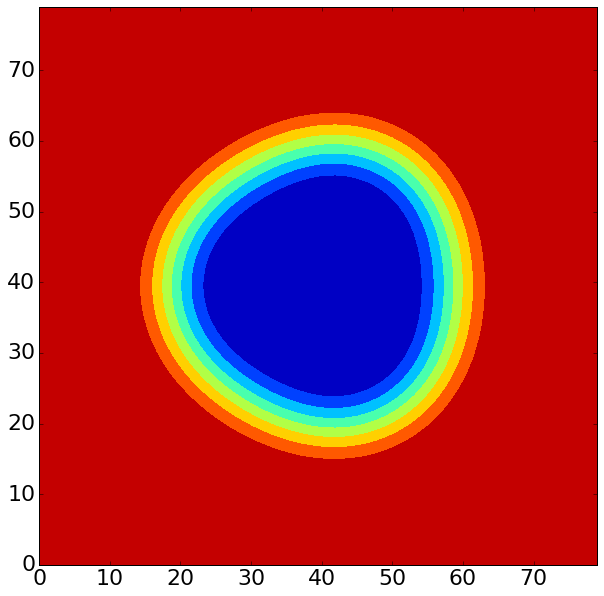

In [17]:
quick,simple = plt.subplots(figsize=(10,10))
simple.contourf(bi[Nz//2]);

### Some vertical cross sections at y=ymax/2

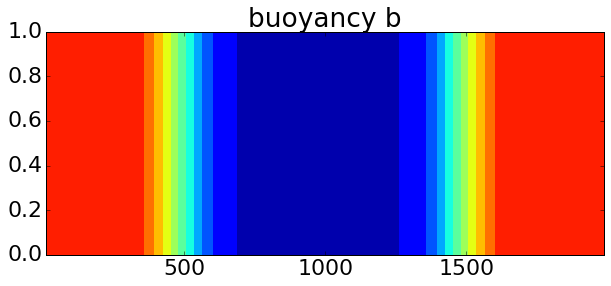

In [18]:
quick,simple = plt.subplots(figsize=(10,4))
cy=Ny//2
simple.contourf( xw[:,cy,:], zw[:,cy,:], bi[:,cy,:], np.linspace(-.12,.12,13))
simple.set_title('buoyancy b');

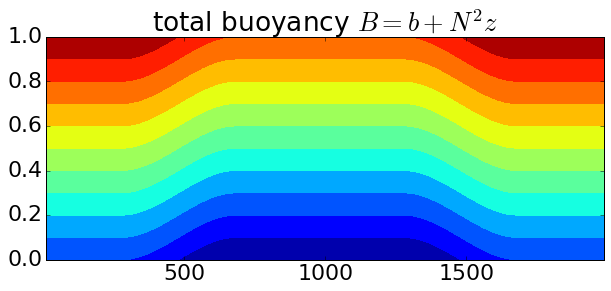

In [19]:
quick,simple = plt.subplots(figsize=(10,4))
btotal = bi + zw
simple.contourf(xw[:,cy,:],zw[:,cy,:],btotal[:,cy,:],np.linspace(-.1,1.1,13))
simple.set_title('total buoyancy $B = b+N^2 z$');

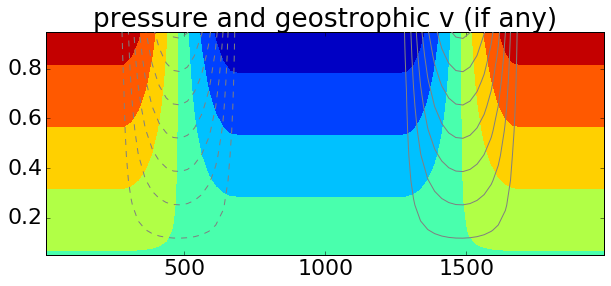

In [20]:
quick,simple = plt.subplots(figsize=(10,4))
simple.contourf(xp[:,cy,:],zp[:,cy,:],pi[:,cy,:])    
simple.contour(xp[:,cy,:],zp[:,cy,:],vi[:,cy,:], np.arange(-1.0125,1.0126,.025), colors='grey', zorder=3)
simple.set_title('pressure and geostrophic v (if any)');

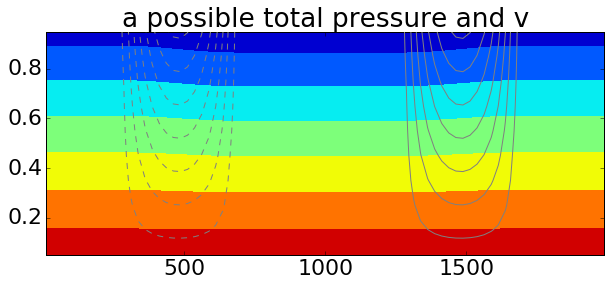

In [21]:
#the 5. is arbitrary ... whatever looks nice to you, as a meteorologist
quick,simple = plt.subplots(figsize=(10,4))
simple.contourf(xp[:,cy,:],zp[:,cy,:],pi[:,cy,:]-.5*(zp[:,cy,:]**2)-5.*zp[:,cy,:])
simple.contour(xp[:,cy,:],zp[:,cy,:],vi[:,cy,:],np.arange(-1.0125,1.0126,.025),colors='grey',zorder=3)
simple.set_title('a possible total pressure and v');

## test of the curtain plot

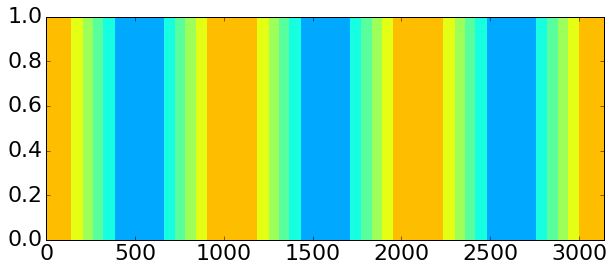

In [22]:
bcur = curtain(ipath,jpath,fpathx,fpathy,bi)
quick,simple = plt.subplots(figsize=(10,4))
simple.contourf( xwcr, zwcr, bcur, np.linspace(-.03,.03,13));

<hr/>
## Set up the animation plot

In [23]:
myfig = plt.figure(figsize=(12,12),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.3333, 0.5333, .5333*ymax/xmax],frameon=False) # contour axes
ax3 = myfig.add_axes([0.02, 0.3333, 0.05333, .5333]) # for colorbar
ax4 = myfig.add_axes([0.7, 0.0500, 0.2, .8]) # for stuff
ax3.axis('off')
ax2.axis('off')
ax1 = myfig.add_axes([0.1, 0.0500, 0.5333, .2666]) # line plot axes
plt.setp( ax2.get_xticklabels(), visible=False);
cbar_exists=False
plt.close()

In [24]:
def doplot():
    global cbar_exists
    
# The "curtain" axis:    
    
    btotal = b + zw
    ax1.clear()
    if fcoriolis==0.:
        ax1.contourf(xw[:,cy,:],zw[:,cy,:],btotal[:,cy,:],np.linspace(-.1,1.1,13))
        ax1.text(0.,-.05*zmax,"total bouyancy in y=ymax/2 plane", fontsize=12)
    else:
        bcur = curtain(ipath,jpath,fpathx,fpathy,b)
        ax1.contourf( xwcr, zwcr, bcur, np.linspace(-.115,.115,24) )
        pcur = curtain(ipath,jpath,fpathx,fpathy,p)
        pcur -= pcur.mean()
        ax1.contour( xpcr, zpcr, pcur, np.linspace(-.145,.145,30), colors='k' )
        wcur = curtain(ipath,jpath,fpathx,fpathy,w)
        ax1.contour( xwcr, zwcr, wcur, np.linspace(-.0000525,.0000525,22), colors='w' )

        curtain_info = "curtain: %5.3f <b< %5.3f  %5.3f <p< %5.3f   %9.2e <w< %9.2e" % \
                      ( bcur.min(),  bcur.max(),  pcur.min(),   pcur.max() , wcur.min(),   wcur.max())
        ax1.text(0, -.05*zmax, curtain_info, fontsize=12)

    ax1.axis('off')
    
    stop_clipping(ax1)
        
# The history axis:
    ax4.clear()
    ax4.plot(ke,times,'r',pe,times,'b',te,times,'g')
    ax4.set_ylim(tstart,tstop)
#    ax4.set_xlim(0,.01)
    ax4.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax4.locator_params(nbins=2)
#       ax4.axis("off")

# the horizontal contour axis:
    ax2.clear()    
    CF = ax2.contourf(xw[kp],yw[kp],b[kp],np.linspace(-.11,.11,12),zorder=1)
  
    pus=p[kp] # pressure surface for white contours
    pus=pus-pus.mean()
    plevs=np.linspace(-.145,.145,30)
    ax2.contour(xp[kp],yp[kp],pus,plevs,colors='w',zorder=2)
    
    pus=p[kq] # pressure surface for green contours
    pus=pus-pus.mean()
    plevs=np.linspace(-.145,.145,30)
    ax2.contour(xp[kq],yp[kq],pus,plevs,colors='g',zorder=2)
    vd=(Nx-1)//40
    
    speedmax=.1
    u_at_p = (u[kp,:,:-1]+u[kp,:,1:])*.5
    v_at_p = (v[kp,:-1,:]+v[kp,1:,:])*.5
    Q = ax2.quiver(xp[kp,::vd,::vd],yp[kp,::vd,::vd],u_at_p[::vd,::vd],v_at_p[::vd,::vd],
            scale=speedmax*Nx/vd,units='width',angles='xy',zorder=3)
    speedf= "%7.3f"  % speedmax
    ax2.quiverkey(Q,-.07,.95,speedmax, speedf,zorder=4)
    ax2.text(.0,-.04*ymax,'t={0:5.0f}'.format(t),fontsize=22)
    ax2.text(.4*xmax,-.04*ymax,'kp={0:d}'.format(kp),fontsize=18)
    expt = "%d,%d,%d  f=%4.3f" % (Nx,Ny,Nz,fcoriolis)
    ax2.text(.6*xmax,-.04*ymax,expt,fontsize=18)
    ax2.axis('off')
    stop_clipping(ax2)

# the colorbar:    
    if not cbar_exists: #bad things happen if cbar is called more than once 
        cbar_exists = True
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.3)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        for boomer in sooner:
            boomer.set_fontsize(12)
    
    clear_output(wait=True)

    display(myfig)   
    tplot = min(tstop,t + dplot)
    if outdir != None: 
        timestamp = round(t,2)
        pngname = outdir+'/%06d.png' % round(timestamp) 
        myfig.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait')  

<hr/>
## Ready to run at t=0

In [25]:
b=bi.copy()
u=ui.copy()
v=vi.copy()
w=wi.copy()
p=pi.copy()

dbdta=[None]*3
dudta=[None]*3
dvdta=[None]*3
dwdta=[None]*3

kp = 0  # index of level for vel vectors, and b, and p with white contours. 0 is standard
kq = -1 # index of level for p with green contours. -1 is standard

te=[] # for time series of total energy in the domain
ke=[] # for time series of total kinetic energy in the domain
pe=[] # for time series or total potential energy in the domain
monitor = [] # for recording a diagnostic quantity at every time step
times = [] # time of the diagnostic
t = 0 #initial time
tstart = 0 # for time series plot
nstep = 0
tplot = 0 # next time to plot
dplot = 1000 # time interval between plots, 1000 for baro, 100 for wave
dt = 50 * 40/(Nx-1)*.5 # where did this come from?? I will leave it as written


<hr/>
## Step forward in time

You can repeatedly increase tstop and rerun the following cell. (Be patient to see the images start to roll again.)

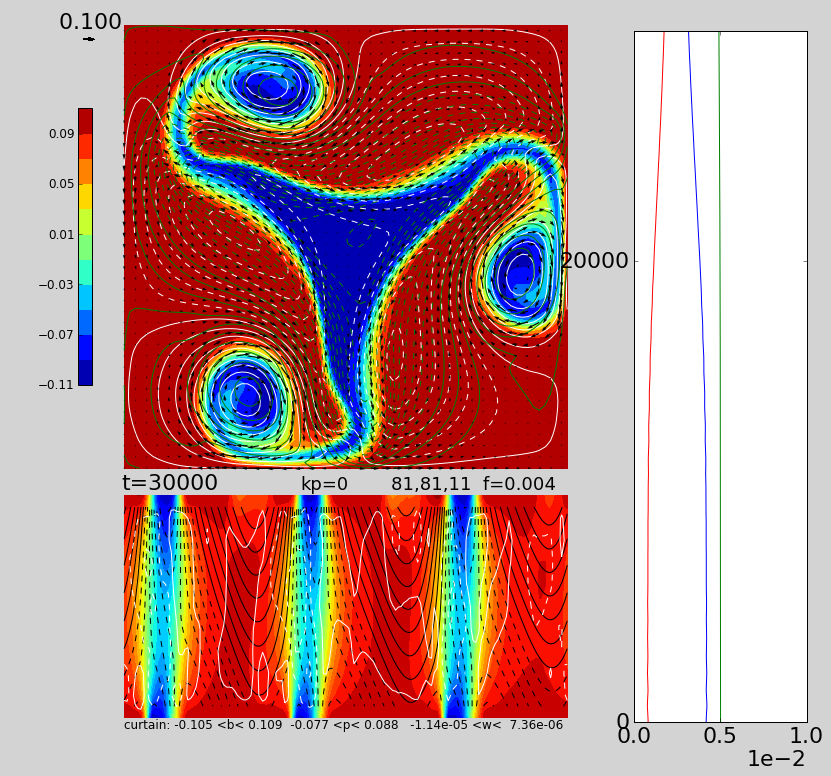

In [27]:
tstop = 30000.  # 30000 for baro, 5000 for baroclinic instability
if fcoriolis==0.: # for pure gravity wave, unbalanced init
    kp = 5 
    tstop = 5000
    

if nstep==0: 
    doplot()
    tplot = min(tstop,tplot + dplot)
    
while t < tstop + dt/2.:
    
    dudt =  advect_3d(u,u,v_to_u(v),w_to_u(w),dx,dy,dz)
    dvdt =  advect_3d(v,u_to_v(u),v,w_to_v(w),dx,dy,dz)
    dbdt =  advect_3d(b,u_to_w(u),v_to_w(v),w,dx,dy,dz)
    dbdt[1:-1,:,:] -= w[1:-1,:,:] 
    if fcoriolis!=0.: dudt +=  fcoriolis*v_to_u(v) #Coriolis term 
    if fcoriolis!=0.: dvdt += -fcoriolis*u_to_v(u) #Coriolis term

# Ensure no normal component of velocity develops on the boundaries:
    if not periodic:
        dudt[:,:,0]=0.
        dudt[:,:,-1]=0.
        dvdt[:,0,:]=0.
        dvdt[:,-1,:]=0.
    

    dudt,dvdt,p = hydrostatic_pressure_3D_Cgrid(dudt,dvdt,b,dx,dy,dz,invlapl,
                                divh_target=0.4*w[-1,:,:]/zmax/dt)       
    p = p-p.mean() # keep p.mean() from drifting


    dudta=[dudt.copy()]+dudta[:-1]
    dvdta=[dvdt.copy()]+dvdta[:-1]
    dbdta=[dbdt.copy()]+dbdta[:-1]
    
#   step forward in time:
    nstep += 1
    abnow = min(nstep,aborder)
    b += dt*ab_blend(dbdta,abnow) 
    u += dt*ab_blend(dudta,abnow) 
    v += dt*ab_blend(dvdta,abnow) 
    t += dt
    
    w = wfromuv_Cgrid(u,v,dx,dy,dz)
    U = u_to_p(u)
    V = v_to_p(v)
    W = w_to_p(w)
    B = w_to_p(b)        
        
    speed = np.sqrt(U*U + V*V + W*W)       
    kinEn = (.5*speed**2).mean()
    potEn = (.5*B**2).mean()
    ke.append(kinEn)
    pe.append(potEn)
    te.append(kinEn+potEn)
    times.append(t)
    if  tplot-dt/2. < t: 
        doplot()
        tplot = tplot + dplot
plt.close()

In [ ]:
nloopmax = 0 # change nloopmax>0 to show images
pngs = glob.glob(outdir+'/*.png')
pngs.sort()
n=0
nloop = 0
while nloop<nloopmax:
    png=pngs[n]
    if not os.path.exists(png):
        print("could not find:",png)  
        break
    n+=1
    if n>=len(pngs):
        n = 0
        nloop+=1
    display(Image(filename=png))
    Time.sleep(.5)
    clear_output(wait=True)
print("completed",nloop,"loops of animation")


# Student Tasks

### 1. Comparison with classical analysis of baroclinic instability.

Immediately below, in the grey plot, is the vertical plane, looking "north", at the fields in a developing baroclinic wave. 
There is cold air to the north. A zonal thermal wind maintains geostrophic balance. Only the departures from
the initial zonal wind are depicted.
In this very idealized symmetric analysis, there is jet stream to the left (west) below and to the right (east) aloft.
The domain in this classic linear analysis is periodic. Though beyond the scope of this course, the details of the analysis can be found [in my 6 page document](http://12characters.net/mathnb/5123lnote/BaroclinicInstabilityEadyModel.pdf), if you are interested. Alternatively, the document is [here](https://www.scribd.com/document/367865262/Baro-Clinic-Instability-Eady-Model).

The plot below, and our curtain plot that, shows our `p`, `b` and `w`.  The **u'** and **v** below do not correspond to our `u` or `v`; some work would be needed to show the velocity components coming in and out of our curtain plot, and that has not been done.

The linear analysis predicts that the most rapidly growing disturbance would have a wavelength of about 4 times the
*Rossby radius of deformation* $L_R$.  In the dimensional world, that radius is $L_R=HN/f$. In our dimensionless model, $N=1$, $H=1$ and $f$ is `fcoriolis`.   With `fcoriolis=.004`, the model Rossby radius is $L_R=250$.  The initial ring of
a jet stream in the model has a circumfrence of 3142, or 1047 per wave, which is about $4*L_R$ per wave. That is close
to the theoretical prediction for the wavelength of the most unstable wave.

White contours are negative, black are positive:
<img src=http://metr4323.net/img/LinearEadyWave.png>

#### Correspondance with our model

Here is the curtain plot during the developing phase with `fcoriolis=.004`, `jet_stream_symmetry=True`
and `ringwave = 3`

<img src=http://metr4323.net/img/BaroclinicInstabilityt15000.png>

**Student Task:**  Describe all the similarities evident between the plots.

### 2. Effect of the Rossby Radius of deformation 

These experiments might be more fun (realistic) with `jet_stream_symmetry=False`

You have learned that the *Rossby radius of deformation* controls the radial extent that a dense dome of air can spread out to, before becoming geostrophically balanced.   What if we initialize with `fcoriolis=.004` and `ringwave=6`? Now  set `fcoriolis=.008`. Compare the simulations with `ringwave=3` and `ringwave=6`.

Is 81x81 sufficient? Especially for `ringwave=6`, we might expect lack of resolution is 
limiting the accuracy. Try repeating a `ringwave=6` simulation with 129x129.  Does the result change much?

Curious to keep exploring? Try initially perturbing the ring with both wavenumbers. Which wavenumber wins?


### 3. A simple gravity wave


Set `fcoriolis=0`.  That will initialize our familiar gaussian initialization of a gravity wave, and set some parameters appropriately.

How much time is required for an internal gravity wave to traval to the boundaries? Is that observation consistent with the phase speed for linear waves?


### 4.  Look at the "500 mb level"

Again, `jet_stream_symmetry=False`, `fcoriolis=.004` and `ringwave=3`, **but** set `kp=5`.  That will give you
a different perspective on cyclone development. 

If you are running Linux or OSX, you can try concatenating images from the surface and mid-level with something like:

`convert +append cycloneskp0/020000.png cycloneskp5/020000.png joined20.png`

(I confess:  I could not produce a "synoptic lab" interpretation of the joint scenario.)

### 5.   Derivation of the hydrostatic solver

Analagous to what we did in a previous notebook for $p(x,z,t)$, derive the theory for the hydrostatic pressure solver for $p(x,y,z,t)$.
